In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import torch

from utils.tools import read_yaml
from utils.plot.abc_parameterizations.initializations import *
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import ntk, ip, muP

### Load basic configuration and define variables 

In [5]:
config_dict = read_yaml(CONFIG_PATH)
base_model_config = ModelConfig(config_dict)

In [6]:
n_trials = 200
widths = [25, 50, 128, 256, 512, 750, 1024, 1200, 1400]
x = 2 * torch.rand(base_model_config.architecture["input_size"], requires_grad=False) - 1

# 1. With ReLU

## NTK 

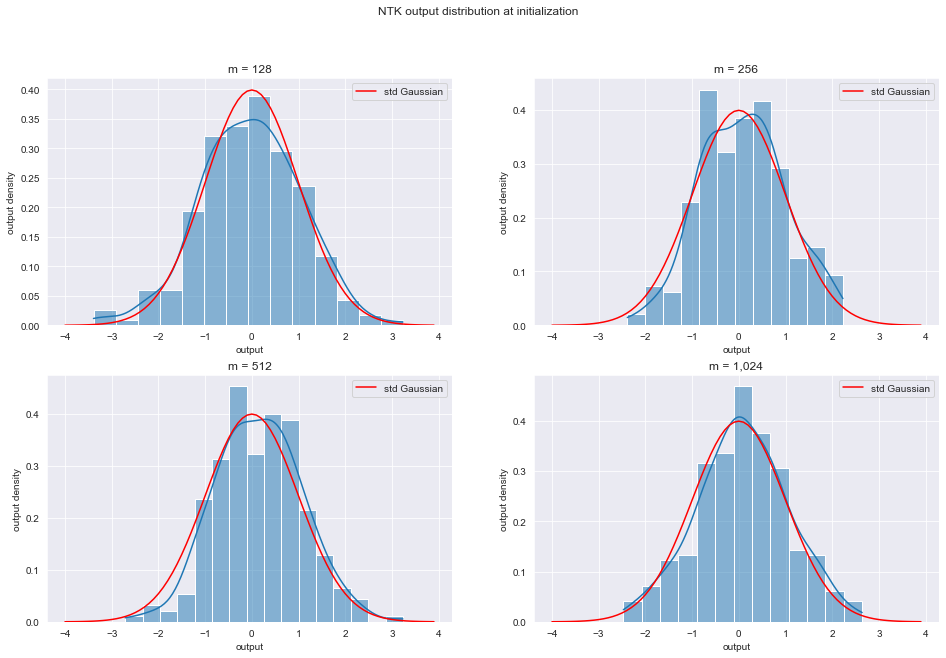

In [7]:
ntk_n_trials = 250
ntk_widths = [128, 256, 512, 1024]
fig_path = os.path.join(FIGURES_DIR, 'ntk_outputs_dist.png')
plot_init_outputs_dist(fig_path, 'NTK', ntk.FCNTK, ntk_n_trials, ntk_widths, base_model_config, x=x, 
                       figsize=(16,10))

### muP

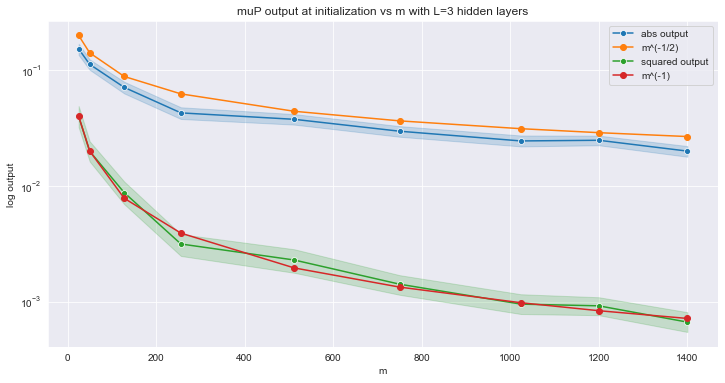

In [8]:
fig_path = os.path.join(FIGURES_DIR, 'muP_outputs.png')
results_df = plot_init_outputs_vs_m(fig_path, 'muP', 1, muP.FCmuP, n_trials, widths, base_model_config, x=x)

### IP

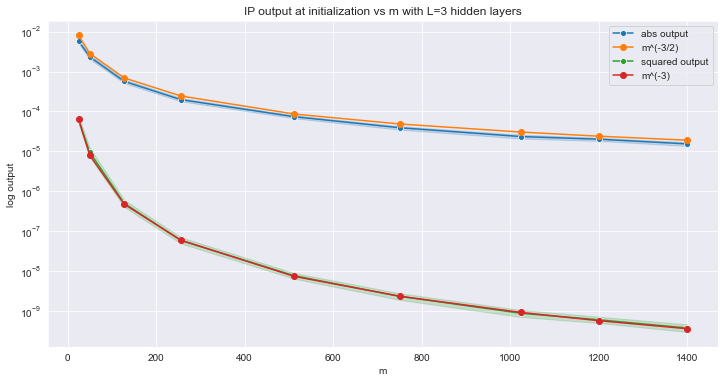

In [9]:
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs.png')
results_df = plot_init_outputs_vs_m(fig_path, 'IP', 3, ip.FCIP, n_trials, widths, base_model_config, x=x, c=0.)

# With GeLU

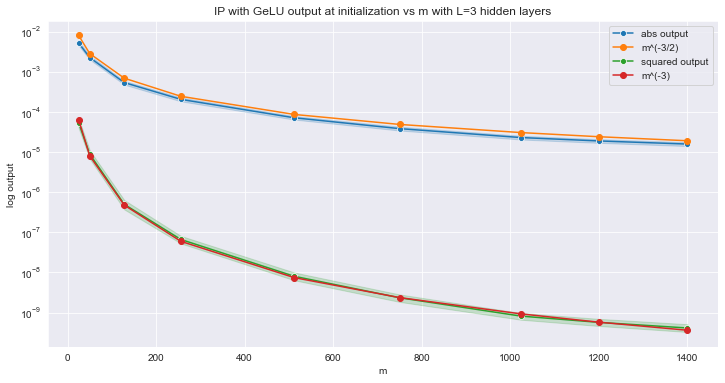

In [10]:
config = deepcopy(base_model_config)
config.activation.name = "gelu"
fig_path = os.path.join(FIGURES_DIR, 'ip_outputs_gelu.png')
results_df = plot_init_outputs_vs_m(fig_path, 'IP with GeLU', 3, ip.FCIP, n_trials, widths, base_model_config, x=x, 
                                    c=0.)